In [1]:
import os
from pathlib import Path
from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import random

In [2]:
import torch
print(torch.__version__)

2.5.1


In [3]:
torch.set_num_threads(os.cpu_count())
print("Threads set to:", os.cpu_count())

Threads set to: 16


In [4]:
serif_root = r"D:\UIUC\School\FA25\CS 441 AML\FinalProject\font_data\data_serif"

In [5]:
class SerifFontLanguageDataset(Dataset):

    def __init__(self, data_sans_root, transform=None):
        self.root = Path(data_sans_root)
        self.transform = transform

        self.lang2idx = {"JP": 0, "KR": 1, "SC": 2, "TC": 3}
        self.idx2lang = {v: k for k, v in self.lang2idx.items()}

        self.samples = []

        png_paths = sorted(self.root.rglob("*.png"))
        print("Raw PNG count under data_sans:", len(png_paths))

        for p in png_paths:
            try:
                lang_dir = p.parents[1].name
            except:
                continue
            if "_" in lang_dir:
                lang_code = lang_dir.split("_")[-1]
            else:
                lang_code = lang_dir[-2:]
            if lang_code not in self.lang2idx:
                continue

            self.samples.append((p, self.lang2idx[lang_code]))
        print("Filtered PNG count (JP/KR/SC/TC):", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        return img, label


In [6]:
class PathLabelDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, label = self.samples[idx]
        img = Image.open(p).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label


def split_by_weight_folders(
    base_dataset,
    train_n=10000, val_n=1500, test_n=1500,
    seed=83
):
    leaf_map = defaultdict(list)

    for img_path, label in base_dataset.samples:
        leaf_map[img_path.parent].append((img_path, label))

    train_samples, val_samples, test_samples = [], [], []

    total_needed = train_n + val_n + test_n
    rng = random.Random(seed)

    for leaf, samples in leaf_map.items():
        rng.shuffle(samples)

        if len(samples) < total_needed:
            continue

        tr = samples[:train_n]
        va = samples[train_n:train_n + val_n]
        te = samples[train_n + val_n:train_n + val_n + test_n]

        train_samples.extend(tr)
        val_samples.extend(va)
        test_samples.extend(te)

    print("Leaf folders found:", len(leaf_map))
    print("Train samples:", len(train_samples))
    print("Val samples:", len(val_samples))
    print("Test samples:", len(test_samples))

    return train_samples, val_samples, test_samples

In [7]:
transform_128 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [8]:
base_ds = SerifFontLanguageDataset(serif_root, transform=None)  

train_samples, val_samples, test_samples = split_by_weight_folders(
    base_dataset=base_ds,
    train_n=10000,
    val_n=1500,
    test_n=1500,
    seed=83
)

train_ds = PathLabelDataset(train_samples, transform=transform_128)
val_ds   = PathLabelDataset(val_samples,   transform=transform_128)
test_ds  = PathLabelDataset(test_samples,  transform=transform_128)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0)


Raw PNG count under data_sans: 315876
Filtered PNG count (JP/KR/SC/TC): 315876
Leaf folders found: 16
Train samples: 160000
Val samples: 24000
Test samples: 24000


In [9]:
x, y = next(iter(train_loader))
print("x shape:", x.shape)
print("y shape:", y.shape)
print("labels example:", y[:10])

x shape: torch.Size([64, 1, 64, 64])
y shape: torch.Size([64])
labels example: tensor([1, 1, 0, 2, 1, 0, 1, 1, 2, 3])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
import torch.nn as nn

class MediumCNNPlus(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

def initializeModel(num_target_classes=4):
    return MediumCNNPlus(num_classes=num_target_classes).to(device)


In [12]:
from matplotlib import pyplot as plt
def plot_results(epochs, train, val, metric_name="Loss"):
    plt.plot(epochs, train, label="train")
    plt.plot(epochs, val, label="val")
    plt.title(metric_name + " Plot")
    plt.ylabel(metric_name)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

In [13]:
import torch
import numpy as np
from tqdm import tqdm

def train(train_loader, model, criterion, optimizer):
    model.train()
    losses = []

    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position=0)
    for i, (images, labels) in it_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.detach())
        it_train.set_description(f'loss: {loss.item():.3f}')

    return torch.stack(losses).mean().item()


def test(test_loader, model, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0

    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position=0)
    with torch.no_grad():
        for i, (images, labels) in it_test:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.detach())

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    mean_accuracy = correct / total if total > 0 else 0.0
    test_loss = torch.stack(losses).mean().item() if len(losses) > 0 else 0.0

    print(f'correct: {correct}, total: {total}')
    print(f'Mean Accuracy: {mean_accuracy:.4f}')
    print(f'Avg loss: {test_loss:.4f}')

    return mean_accuracy, test_loss


In [14]:
import sys
print(sys.executable)

c:\Users\sam\anaconda3\envs\pyCS441Final\python.exe


In [15]:
device = torch.device("cpu")  

loss: 0.968: 100%|██████████| 2500/2500 [13:14<00:00,  3.14it/s]


Train loss epoch 0: 1.0605391263961792


Validating ...: 100%|██████████| 2500/2500 [02:33<00:00, 16.32it/s]


correct: 71358, total: 160000
Mean Accuracy: 0.4460
Avg loss: 1.1348


Training:   7%|▋         | 1/15 [17:54<4:10:47, 1074.82s/it]

correct: 10637, total: 24000
Mean Accuracy: 0.4432
Avg loss: 1.1496
Train acc: 0.4459875 | Val acc: 0.4432083333333333
Saved best model


loss: 0.900: 100%|██████████| 2500/2500 [04:44<00:00,  8.80it/s]


Train loss epoch 1: 0.9452649354934692


Validating ...: 100%|██████████| 2500/2500 [02:33<00:00, 16.33it/s]


correct: 87903, total: 160000
Mean Accuracy: 0.5494
Avg loss: 0.9239


Training:  13%|█▎        | 2/15 [25:34<2:34:30, 713.11s/it] 

correct: 13024, total: 24000
Mean Accuracy: 0.5427
Avg loss: 0.9459
Train acc: 0.54939375 | Val acc: 0.5426666666666666
Saved best model


loss: 0.791: 100%|██████████| 2500/2500 [08:16<00:00,  5.03it/s]


Train loss epoch 2: 0.8914684653282166


Validating ...: 100%|██████████| 2500/2500 [08:19<00:00,  5.00it/s]


correct: 71800, total: 160000
Mean Accuracy: 0.4487
Avg loss: 1.2458


Training:  20%|██        | 3/15 [42:34<2:50:37, 853.11s/it]

correct: 10677, total: 24000
Mean Accuracy: 0.4449
Avg loss: 1.2822
Train acc: 0.44875 | Val acc: 0.444875


loss: 0.632: 100%|██████████| 2500/2500 [24:31<00:00,  1.70it/s]


Train loss epoch 3: 0.8261653184890747


Validating ...: 100%|██████████| 2500/2500 [11:58<00:00,  3.48it/s]


correct: 96052, total: 160000
Mean Accuracy: 0.6003
Avg loss: 0.8390


Training:  27%|██▋       | 4/15 [1:20:47<4:20:39, 1421.73s/it]

correct: 14095, total: 24000
Mean Accuracy: 0.5873
Avg loss: 0.8612
Train acc: 0.600325 | Val acc: 0.5872916666666667
Saved best model


loss: 0.741: 100%|██████████| 2500/2500 [26:08<00:00,  1.59it/s]


Train loss epoch 4: 0.7963340282440186


Validating ...: 100%|██████████| 2500/2500 [12:00<00:00,  3.47it/s]


correct: 101838, total: 160000
Mean Accuracy: 0.6365
Avg loss: 0.7657


Training:  33%|███▎      | 5/15 [2:00:41<4:55:22, 1772.20s/it]

correct: 14710, total: 24000
Mean Accuracy: 0.6129
Avg loss: 0.8084
Train acc: 0.6364875 | Val acc: 0.6129166666666667
Saved best model


loss: 0.783: 100%|██████████| 2500/2500 [23:09<00:00,  1.80it/s]


Train loss epoch 5: 0.7767404317855835


Validating ...: 100%|██████████| 2500/2500 [04:56<00:00,  8.42it/s]


correct: 104002, total: 160000
Mean Accuracy: 0.6500
Avg loss: 0.7416


Training:  40%|████      | 6/15 [2:29:10<4:22:35, 1750.56s/it]

correct: 14814, total: 24000
Mean Accuracy: 0.6172
Avg loss: 0.8087
Train acc: 0.6500125 | Val acc: 0.61725
Saved best model


loss: 0.605: 100%|██████████| 2500/2500 [04:48<00:00,  8.67it/s]


Train loss epoch 6: 0.7410151362419128


Validating ...: 100%|██████████| 2500/2500 [02:40<00:00, 15.58it/s]


correct: 104634, total: 160000
Mean Accuracy: 0.6540
Avg loss: 0.7283


Training:  47%|████▋     | 7/15 [2:37:04<2:57:47, 1333.38s/it]

correct: 14701, total: 24000
Mean Accuracy: 0.6125
Avg loss: 0.8366
Train acc: 0.6539625 | Val acc: 0.6125416666666667


loss: 0.714: 100%|██████████| 2500/2500 [05:47<00:00,  7.19it/s]


Train loss epoch 7: 0.7272006869316101


Validating ...: 100%|██████████| 2500/2500 [02:47<00:00, 14.89it/s]


correct: 104880, total: 160000
Mean Accuracy: 0.6555
Avg loss: 0.7246


Training:  53%|█████▎    | 8/15 [2:46:05<2:06:07, 1081.06s/it]

correct: 14801, total: 24000
Mean Accuracy: 0.6167
Avg loss: 0.8209
Train acc: 0.6555 | Val acc: 0.6167083333333333


loss: 0.604: 100%|██████████| 2500/2500 [05:46<00:00,  7.21it/s]


Train loss epoch 8: 0.7172099351882935


Validating ...: 100%|██████████| 2500/2500 [02:28<00:00, 16.82it/s]


correct: 103424, total: 160000
Mean Accuracy: 0.6464
Avg loss: 0.7433


Training:  60%|██████    | 9/15 [2:54:42<1:30:29, 904.85s/it] 

correct: 14497, total: 24000
Mean Accuracy: 0.6040
Avg loss: 0.8575
Train acc: 0.6464 | Val acc: 0.6040416666666667


loss: 0.588: 100%|██████████| 2500/2500 [05:15<00:00,  7.93it/s]


Train loss epoch 9: 0.6965906023979187


Validating ...: 100%|██████████| 2500/2500 [02:46<00:00, 15.01it/s]


correct: 107457, total: 160000
Mean Accuracy: 0.6716
Avg loss: 0.6893


Training:  67%|██████▋   | 10/15 [3:03:10<1:05:12, 782.41s/it]

correct: 15128, total: 24000
Mean Accuracy: 0.6303
Avg loss: 0.7853
Train acc: 0.67160625 | Val acc: 0.6303333333333333
Saved best model


loss: 0.600: 100%|██████████| 2500/2500 [05:50<00:00,  7.13it/s]


Train loss epoch 10: 0.6899638175964355


Validating ...: 100%|██████████| 2500/2500 [02:46<00:00, 15.01it/s]


correct: 109133, total: 160000
Mean Accuracy: 0.6821
Avg loss: 0.6773


Training:  73%|███████▎  | 11/15 [3:12:10<47:12, 708.04s/it]  

correct: 15106, total: 24000
Mean Accuracy: 0.6294
Avg loss: 0.7686
Train acc: 0.68208125 | Val acc: 0.6294166666666666


loss: 0.804: 100%|██████████| 2500/2500 [04:48<00:00,  8.68it/s]


Train loss epoch 11: 0.6837528347969055


Validating ...: 100%|██████████| 2500/2500 [02:47<00:00, 14.93it/s]


correct: 109915, total: 160000
Mean Accuracy: 0.6870
Avg loss: 0.6545


Training:  80%|████████  | 12/15 [3:20:10<31:56, 638.82s/it]

correct: 15123, total: 24000
Mean Accuracy: 0.6301
Avg loss: 0.7826
Train acc: 0.68696875 | Val acc: 0.630125


loss: 0.747: 100%|██████████| 2500/2500 [05:48<00:00,  7.18it/s]


Train loss epoch 12: 0.6721164584159851


Validating ...: 100%|██████████| 2500/2500 [02:48<00:00, 14.80it/s]


correct: 110453, total: 160000
Mean Accuracy: 0.6903
Avg loss: 0.6464


Training:  87%|████████▋ | 13/15 [3:29:13<20:19, 609.82s/it]

correct: 15169, total: 24000
Mean Accuracy: 0.6320
Avg loss: 0.7815
Train acc: 0.69033125 | Val acc: 0.6320416666666666
Saved best model


loss: 0.593: 100%|██████████| 2500/2500 [05:48<00:00,  7.17it/s]


Train loss epoch 13: 0.6688821315765381


Validating ...: 100%|██████████| 2500/2500 [02:39<00:00, 15.72it/s]


correct: 110661, total: 160000
Mean Accuracy: 0.6916
Avg loss: 0.6436


Training:  93%|█████████▎| 14/15 [3:38:03<09:45, 585.49s/it]

correct: 15178, total: 24000
Mean Accuracy: 0.6324
Avg loss: 0.7795
Train acc: 0.69163125 | Val acc: 0.6324166666666666
Saved best model


loss: 0.677: 100%|██████████| 2500/2500 [04:59<00:00,  8.35it/s]


Train loss epoch 14: 0.6651878356933594


Validating ...: 100%|██████████| 2500/2500 [02:46<00:00, 15.03it/s]


correct: 109520, total: 160000
Mean Accuracy: 0.6845
Avg loss: 0.6551


Training: 100%|██████████| 15/15 [3:46:13<00:00, 904.93s/it]


correct: 14967, total: 24000
Mean Accuracy: 0.6236
Avg loss: 0.8290
Train acc: 0.6845 | Val acc: 0.623625


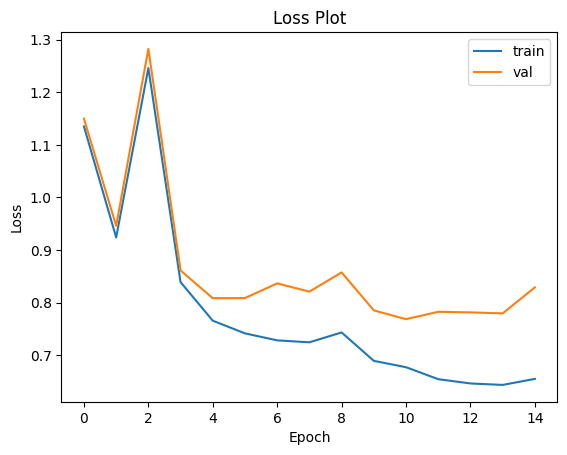

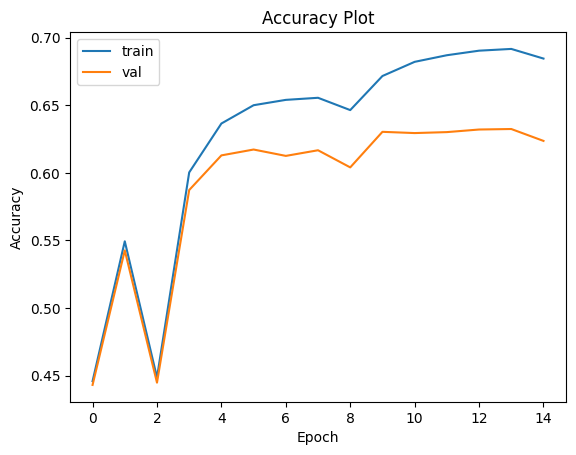

C:\Users\sam\AppData\Local\Temp\ipykernel_64200\97822465.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
Validating ...: 10

correct: 15274, total: 24000
Mean Accuracy: 0.6364
Avg loss: 0.7753
Final Test acc: 0.6364166666666666
Final Test loss: 0.7752890586853027


In [16]:
import os
from tqdm import tqdm

save_dir = "./checkpoints_lang_sans"
os.makedirs(save_dir, exist_ok=True)

model = initializeModel(num_target_classes=4)

num_epochs = 15
test_interval = 1

learn_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

criterion = torch.nn.CrossEntropyLoss()

epochs_list = []
train_losses = []
train_accuracy_list = []
val_losses = []
val_accuracy_list = []

for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training"):

    train_loss = train(train_loader, model, criterion, optimizer)
    lr_scheduler.step()

    print(f"Train loss epoch {epoch}: {train_loss}")

    if (epoch % test_interval == 0) or (epoch == num_epochs - 1):
        epochs_list.append(epoch)

        train_acc, train_loss_eval = test(train_loader, model, criterion)
        train_losses.append(train_loss_eval)
        train_accuracy_list.append(train_acc)

        val_acc, val_loss = test(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_accuracy_list.append(val_acc)

        print(f"Train acc: {train_acc} | Val acc: {val_acc}")

        if len(val_accuracy_list) == 1 or val_acc >= max(val_accuracy_list[:-1]):
            save_checkpoint(save_dir, model, save_name="best_model.pth")
            print("Saved best model")

plot_results(epochs_list, train_losses, val_losses, "Loss")
plot_results(epochs_list, train_accuracy_list, val_accuracy_list, "Accuracy")

model = initializeModel(num_target_classes=4)
load_model(model, save_dir, save_name="best_model.pth")

test_acc, test_loss = test(test_loader, model, criterion)
print("Final Test acc:", test_acc)
print("Final Test loss:", test_loss)


In [17]:
def get_preds_labels(model, loader, device):
    model.eval()
    preds_all, labels_all = [], []

    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        preds_all.append(preds)
        labels_all.append(labels.numpy())

    return np.concatenate(preds_all), np.concatenate(labels_all)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix


model = model.to(device)


preds, labels = get_preds_labels(model, test_loader, device)

print("\nClassification report:")
print(classification_report(
    labels, preds,
    target_names=["JP", "KR", "SC", "TC"],
    digits=4
))

print("Confusion matrix:")
print(confusion_matrix(labels, preds))



Classification report:
              precision    recall  f1-score   support

          JP     0.5037    0.8932    0.6441      6000
          KR     0.9877    0.5637    0.7177      6000
          SC     0.6609    0.5343    0.5909      6000
          TC     0.6541    0.5545    0.6002      6000

    accuracy                         0.6364     24000
   macro avg     0.7016    0.6364    0.6383     24000
weighted avg     0.7016    0.6364    0.6383     24000

Confusion matrix:
[[5359   15  290  336]
 [2376 3382  119  123]
 [1481   13 3206 1300]
 [1423   14 1236 3327]]
